# Hierarchical clustering based on sequence similarity

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed

# --Machine learning and statistics
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.preprocessing import TimeSeriesResampler
from tslearn.metrics import dtw_path


# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import  define_trial_types, bin_sequence
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering//'
os.chdir(functions_path)
from clustering_functions import GMM_neg_log_likelihood
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files

from one.api import ONE
one = ONE(mode='remote')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [15]:

import numpy as np
# from cuml.metrics import pairwise_distances
import cupy as cp
# Example: Convert NumPy array to CuPy
np_array = np.random.rand(1000, 1000)  # Example data
cp_array = cp.array(np_array)  # Move to GPU

# Perform operations on GPU
result = cp.dot(cp_array, cp_array.T)

# Move back to CPU if needed
np_result = cp.asnumpy(result)


In [16]:
np.dot(np_array, np_array.T)

array([[329.30932098, 246.05302688, 250.34766754, ..., 246.01960598,
        236.82216065, 255.31258732],
       [246.05302688, 333.66382476, 251.63596508, ..., 244.22057568,
        242.32920643, 259.83306138],
       [250.34766754, 251.63596508, 337.79823811, ..., 251.23557426,
        244.85111884, 266.72693013],
       ...,
       [246.01960598, 244.22057568, 251.23557426, ..., 326.44750517,
        236.33499017, 254.38065826],
       [236.82216065, 242.32920643, 244.85111884, ..., 236.33499017,
        316.51302204, 251.4778565 ],
       [255.31258732, 259.83306138, 266.72693013, ..., 254.38065826,
        251.4778565 , 352.30838876]])

In [9]:
np_array = np.random.rand(100)  # Example data
np.shape(cp_array)

(4,)

In [6]:
import cupyx.scipy.spatial.distance as distance

In [10]:
cp_array

array([9, 4, 6, 3])

In [11]:
np_array = np.random.rand(100)  # Example data
cp_array = cp.array(np.array([9, 4, 6, 3]))  # Move to GPU
distance.hamming([4, 1, 8, 34], [9, 2, 6,4])

AttributeError: 'list' object has no attribute 'flags'

In [11]:
cp_array

array([[0.13501698, 0.6356508 , 0.45574281, ..., 0.91406001, 0.46505668,
        0.4466312 ],
       [0.37402566, 0.2990443 , 0.12598426, ..., 0.57201278, 0.52861848,
        0.8852656 ],
       [0.94395751, 0.7201544 , 0.05921848, ..., 0.17624078, 0.98773927,
        0.96686321],
       ...,
       [0.96186604, 0.42027962, 0.21426153, ..., 0.01622481, 0.98127684,
        0.60462803],
       [0.57701244, 0.18655526, 0.38328183, ..., 0.58863312, 0.18449467,
        0.54731593],
       [0.54565168, 0.05609029, 0.9187241 , ..., 0.13601822, 0.62070669,
        0.31356465]])

In [10]:
np.shape(np_result)

(10000, 10000)

In [3]:
from cuml.metrics import pairwise_distances
print("cuML is installed successfully!")

ModuleNotFoundError: No module named 'cuml'

## Parameters

In [4]:
# Parameters
bin_size = 0.017
num_states = 2
optimal_k = 4
# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [5]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Get sequence distances per trial epoch and type

In [6]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/1_HMM_states/'
filename = str(results_path + 'distance_matrix_correct 0.125 0.5 right03-05-2025')
file = np.load(filename)

## Compute DTW hamming distances

In [79]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from fastdtw import fastdtw
from scipy.spatial.distance import hamming


def plot_dendrogram(distance_matrix, title="Hierarchical Clustering"):
    """
    Performs hierarchical clustering and plots a dendrogram.
    """
    linkage_matrix = sch.linkage(distance_matrix, method='average', metric='hamming')
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage_matrix, leaf_rotation=90)
    plt.title(title)
    plt.show()

In [95]:
sessions = design_df['session'].unique()
epochs = all_sequences['broader_label'].unique()
trial_types = design_df['trial_type'].unique()
n_jobs = -1  # Uses all available cores

for e, epoch in enumerate(epochs[:1]):
    
    for t, type in enumerate(trial_types):
        use_data = design_df.loc[design_df['trial_type']==type]
        sequences_per_epoch = use_data[[epoch]].dropna().apply(lambda row: np.hstack(row), axis=1)  # Transpose to get the right shape
        sequences = [np.array(seq) for seq in sequences_per_epoch]       

        n = len(sequences)
        print(type, n)

correct 0.125 0.5 right 1677
correct 1.0 0.5 right 1951
correct 1.0 0.8 right 10668
correct 0.25 0.8 right 10418
correct 0.125 0.8 right 8859
incorrect 0.0625 0.8 right 1338
correct 0.0625 0.8 right 7447
correct 0.0625 0.5 right 1374
correct 1.0 0.8 left 2507
correct 0.25 0.8 left 1863
incorrect 0.25 0.5 right 183
correct 0.0 0.8 right 3505
correct 0.25 0.2 left 9218
correct 0.125 0.2 right 1782
incorrect 0.125 0.2 right 1260
correct 1.0 0.2 right 2257
incorrect 0.25 0.2 right 654
incorrect 0.0 0.2 right 1786
incorrect 0.0625 0.2 right 2299
correct 0.0625 0.2 right 1215
correct 0.0 0.2 left 3918
correct 0.0625 0.2 left 7978
correct 0.125 0.2 left 8584
correct 0.0 0.2 right 319
correct 1.0 0.2 left 9990
correct 0.0 0.5 right 521
correct 0.25 0.2 right 2021
incorrect 0.25 0.2 left 504
correct 0.25 0.5 right 1897
incorrect 0.0 0.2 left 827
correct 1.0 0.5 left 1968
incorrect 0.125 0.2 left 1016
incorrect 0.125 0.5 right 398
incorrect 0.0625 0.2 left 1521
incorrect 1.0 0.8 left 265
incorre

In [1]:
linkage_matrix = sch.linkage(distance_matrix, method='average', metric='hamming')
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix, leaf_rotation=90)

NameError: name 'sch' is not defined

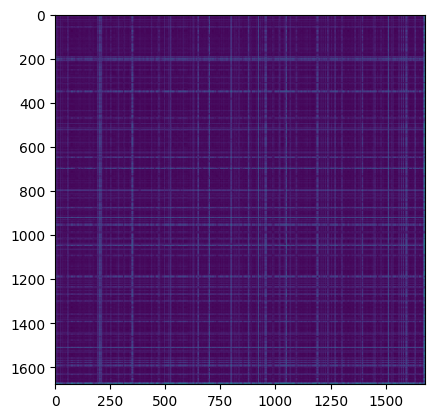

In [77]:
plt.imshow(distance_matrix)